In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from string import ascii_lowercase
import pandas as pd
from joblib import Parallel, delayed
from functions import *
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import getpass
import os

user = getpass.getuser()
path = "/home/%s/Pesquisa/TunableBilliard/Data" % user

## Fixed position, different $h$

### Two exits

#### Plot the survival probability

In [2]:
gamma = 3
eps = 0.45
h_ini = 0.01
h_end = 0.20
dh = 0.01
hs = np.arange(h_ini, h_end + dh, dh)
hs = hs[::-1]
N = int(1e6)
eN = int(np.log10(N))
bN = int(N/10**(eN))
n_ic = int(1e6)
enic = int(np.log10(n_ic))
bnic = int(n_ic/10**(enic))

In [21]:
plot_params(legend_fontsize=11, fontsize=19, tick_labelsize=16)
hs = [0.01, 0.05, 0.08, 0.12, 0.15, 0.2]
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 4))
lw = 0.75
colors = ["k", "r", "b", "g", "gold", "darkviolet"]
xbox = 0.01
ybox = 0.939
bbox = {'linewidth': 0.0, 'facecolor': 'w', 'alpha': 0.75, 'pad': 1}
for i, h in enumerate(hs):
    df = "%s/survival_prob_gamma=%i_eps=%.5f_h=%.3f_N=%ie%i_nic=%ie%i.dat" % (path, gamma, eps, h, bN, eN, bnic, enic)
    df = pd.read_csv(df, header=None, delim_whitespace=True)
    x = np.array(df[0])
    y = np.array([np.array(df[j]) for j in range(1, len(df.columns))])
    for j in range(2):
        ax[j].plot(x, y[j], lw=lw, c=colors[i], label="$h = %.2f$" % h)
for j in range(2):
    ax[j].text(xbox, ybox, "(%s)" % (ascii_lowercase[j]), transform=ax[j].transAxes, bbox=bbox)
ax[0].legend(loc="lower left", frameon=False)
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim(1, N)
ax[0].set_ylim(1e-6, 1.1e0)
ax[0].set_ylabel("Survival probability")
for j in range(2):
    ax[j].set_xlabel("$n$")
plt.subplots_adjust(left=0.1375, bottom=0.14, right=0.9725, top=0.978, hspace=0.05, wspace=0.13)
plt.savefig("Figures/survival_prob_2exits.png", dpi=500)
plt.close()

<Figure size 640x480 with 0 Axes>

#### Calculates the escape rate as a function of $h$

In [4]:
h_ini = 0.01
h_end = 0.20
dh = 0.01
hs = np.arange(h_ini, h_end + dh, dh)
if hs[-1] != h_end:
    hs = hs[:-1]
A = np.zeros((len(hs), 2))
for i, h in enumerate(hs):
    df = "%s/survival_prob_gamma=%i_eps=%.5f_h=%.3f_N=%ie%i_nic=%ie%i_A.dat" % (path, gamma, eps, h, bN, eN, bnic, enic)
    df = pd.read_csv(df, header=None, delim_whitespace=True)
    x = np.array(df[0])
    y = np.array([np.array(df[j]) for j in range(1, len(df.columns))])
    for j in range(A.shape[1]):
        #fit = np.where(y[j] > 7e-3)
        fit = np.where(y[j] > 7e-2)
        x_fit = x[fit]
        y_fit = y[j][fit]
        A[i, j], _ = np.polyfit(x_fit, np.log(y_fit), 1)

<Figure size 640x480 with 0 Axes>

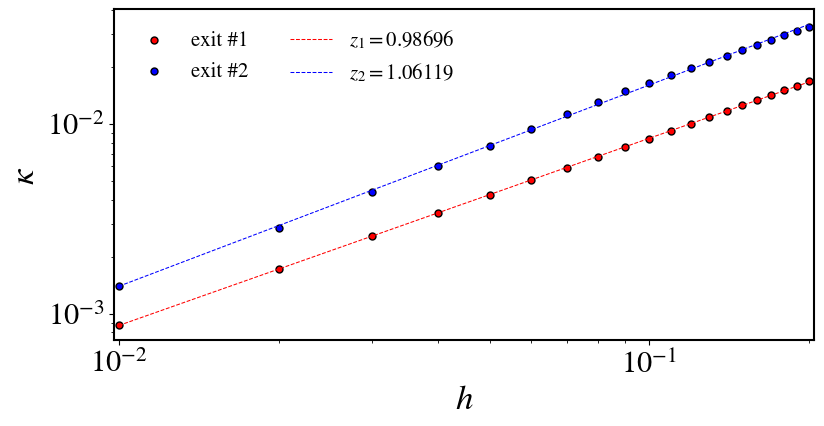

In [6]:
plot_params(fontsize=25, legend_fontsize=15, axes_linewidth=1.5)
fig, ax = plt.subplots(figsize=(8, 4))
lw = 0.75
ms = 25
colors = ["r", "b", "g", "gold", "darkviolet"]
h_ini = 0.01
h_end = 0.20
dh = 0.01
hs = np.arange(h_ini, h_end + dh, dh)
z = np.zeros((A.shape[1], 2))
start = [0, 0, 2, 2]
for j in range(A.shape[1]):
    plt.scatter(hs, -A[:, j], s=ms, c=colors[j], label="exit #%i" % (j + 1), edgecolors="black")
for j in range(A.shape[1]):
    z[j, 0], z[j, 1] = np.polyfit(np.log10(hs[start[j]:]), np.log10(-A[start[j]:, j]), 1)

    x_new = np.linspace(hs.min(), hs.max(), 1000)
    y_new = (10**(z[j, 1]))*x_new**(z[j, 0])
    plt.plot(x_new, y_new, "--", lw=lw, c=colors[j], label="$z_{%i} = %.5f$" % (j + 1, z[j, 0]))

plt.legend(loc="best", frameon=False, ncol=2)
plt.xlabel("$h$")
plt.ylabel("$\kappa$")
plt.xscale("log")
plt.yscale("log")
plt.xlim(9.8e-3, 2.05e-1)
plt.subplots_adjust(left=0.12, bottom=0.1675, right=0.995, top=0.995)
plt.savefig("Figures/escape_rates_2exits.png", dpi=500)

#### Transform the horizontal axis and collapses all the survival probability curves

In [55]:
plot_params(legend_fontsize=11, fontsize=19, tick_labelsize=16)
hs = [0.01, 0.05, 0.08, 0.12, 0.15, 0.2]
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 4))
lw = 0.75
colors = ["k", "r", "b", "g", "gold", "darkviolet"]
xbox = 0.01
ybox = 0.939
bbox = {'linewidth': 0.0, 'facecolor': 'w', 'alpha': 0.75, 'pad': 1}
for i, h in enumerate(hs):
    df = "%s/survival_prob_gamma=%i_eps=%.5f_h=%.3f_N=%ie%i_nic=%ie%i_A.dat" % (path, gamma, eps, h, bN, eN, bnic, enic)
    df = pd.read_csv(df, header=None, delim_whitespace=True)
    x = np.array(df[0])
    y = np.array([np.array(df[j]) for j in range(1, len(df.columns))])
    for j in range(2):
        ax[j].plot(x*(h**z[j, 0]), y[j], lw=lw, c=colors[i], label="$h = %.2f$" % h)
for j in range(2):
    ax[j].text(xbox, ybox, "(%s)" % (ascii_lowercase[j]), transform=ax[j].transAxes, bbox=bbox)
ax[0].legend(loc="lower left", frameon=False)
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim(1e-1, 1.5e2)
ax[0].set_ylim(1e-3, 1.1e0)
ax[0].set_ylabel("Survival probability")
for j in range(2):
    ax[j].set_xlabel("$nh^{z_{%i}}$" % (j + 1))
plt.subplots_adjust(left=0.1375, bottom=0.14, right=0.9725, top=0.978, hspace=0.05, wspace=0.13)
plt.savefig("Paper/Figures/survival_prob_SI2exits.png", dpi=500)
plt.close()

<Figure size 640x480 with 0 Axes>

## Fixed $h$, different positions

In [3]:
gamma = 3
eps = 0.45
ehs = np.array([2*np.pi/3, 5*np.pi/7, 47*np.pi/63, 7*np.pi/9, 5*np.pi/6, 12*np.pi/13, 17*np.pi/18, 29*np.pi/30, 89*np.pi/90, np.pi]) #np.linspace(ehs_ini, ehs_end, 100)
N = int(1e6)
eN = int(np.log10(N))
bN = int(N/10**(eN))
n_ic = int(5e6)
enic = int(np.log10(n_ic))
bnic = int(n_ic/10**(enic))
h = 0.20
labels = ["$\\theta_{\\mathrm{exit}} = 2\\pi/3$", "$\\theta_{\\mathrm{exit}} = 5\\pi/7$", "$\\theta_{\\mathrm{exit}} = 47\\pi/63$", "$\\theta_{\\mathrm{exit}} = 7\\pi/9$", "$\\theta_{\\mathrm{exit}} = 5\\pi/6$", "$\\theta_{\\mathrm{exit}} = 12\\pi/13$", "$\\theta_{\\mathrm{exit}} = 17\\pi/18$", "$\\theta_{\\mathrm{exit}} = 29\\pi/30$", "$\\theta_{\\mathrm{exit}} = 89\\pi/90$", "$\\theta_{\\mathrm{exit}} = \\pi$"]

In [4]:
num_coll = int(3e4)
num_ic = 150
np.random.seed(15)
theta = np.random.uniform(0, 2*np.pi, num_ic)
alpha = np.random.uniform(0, np.pi, num_ic)

ps = np.array(Parallel(n_jobs=-1)(delayed(phase_space)(theta[i], alpha[i], gamma, eps, num_coll) for i in range(num_ic)))
ps = ps.reshape((num_ic*(num_coll + 1), 2))

In [6]:
plot_params(fontsize=16, tick_labelsize=13, legend_fontsize=9, axes_linewidth=1.1)
fig, ax = plt.subplots(2, 1, figsize=(5, 7))
colors = ["r", "b", "g", "gold", "darkviolet", "grey", "orange", "lime", "cyan", "k"]
lw = 0.6
ms = 3
xbox = 0.0065
ybox = 0.934
bbox = {'linewidth': 0.0, 'facecolor': "w", 'alpha': 0.75, 'pad': 1}
for i, eh in enumerate(ehs):
    df = "%s/survival_prob_vs_pos_gamma=%i_eps=%.5f_h=%.3f_N=%ie%i_nic=%ie%i_eh=%.10f.dat" % (path, gamma, eps, h, bN, eN, bnic, enic, eh)
    df = pd.read_csv(df, header=None, delim_whitespace=True)
    x = np.array(df[0])
    y = np.array(df[1])
    ax[0].plot(x, y, "-", lw=lw, c=colors[i], label=labels[i])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].legend(loc="upper right", frameon=False, ncol=1)
ax[0].set_xlim(1e0, N)
ax[0].set_ylim(1e-6, 1.1e0)
ax[0].set_xlabel("$n$")
ax[0].set_ylabel("Survival probability")

ax[1].plot(ps[:, 0], ps[:, 1], "ko", markersize=0.25, markeredgewidth=0.0)
ax[1].set_xlim(np.pi/3, np.pi)
ax[1].set_ylim(0, np.pi)
ax[1].set_yticks([0, np.pi/2, np.pi])
ax[1].set_yticklabels(["$0$", "$\\pi/2$", "$\\pi$"])
ax[1].set_ylabel("$\\alpha$")
ax[1].set_xticks([np.pi/3, np.pi/2, 3*np.pi/4, np.pi])
ax[1].set_xticklabels(["$\\pi/3$", "$\\pi/2$", "$3\\pi/4$", "$\\pi$"])
ax[1].set_xlabel("$\\theta$")

for i in range(ehs.shape[0]):
    ax[1].plot([ehs[i], ehs[i]], [0, np.pi], "--", c=colors[i], lw=lw)

[ax[i].text(xbox, ybox, "(%s)" % ascii_lowercase[i], transform=ax[i].transAxes, bbox=bbox) for i in range(ax.shape[0])]

plt.tight_layout(h_pad=0.025)
plt.savefig("Figures/surv_prob_vs_pos_h=%.3f.png" % h, dpi=500, bbox_inches="tight")
plt.close()

<Figure size 640x480 with 0 Axes>